# Implement YOLOV3 from `YunYang94` code

[Source code](https://github.com/YunYang1994/TensorFlow2.0-Examples/tree/f99fcef22caa2758b5eefce10ee789384345506d/4-Object_Detection/YOLOV3) that this project is based on.

----

Todo :
1. Create a pipeline for a video :
    - Load video
    - Convert video to N frames
    - Predict on each frame if there is any object using YoloV3
        - if yes : draw boxes and label on top
    - Regroup all frames in the same video
    
2. Update YoloV3 model for drone use case :
    - Load and prepare data for train
        - csv labels (x_min, y_min, x_max, y_max) to bboxes `at first only on class`
        - check one one random img (5 ~ 6 times to be sure)
    - Change config (simplify it)
    - Check needed files / functions
    - Try to train
    - ...
  

## Load packages

In [1]:
import cv2
import time
import numpy as np
import pandas as pd
import core.utils as utils
import tensorflow as tf
# from core.yolov3 import YOLOv3, decode

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gc

In [2]:
print('tensorflow version:', tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.per_process_gpu_memory_fraction = 0.3

tensorflow version: 2.1.0


In [4]:
# tf.config.experimental.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 1. Load video and predict on each frame

In [5]:
video_path      = "/data/archives/1.1.11.MP4"
# video_path      = 0
num_classes     = 80
input_size      = 416

Load YOLOV3 model

In [5]:
# Load from weight file

# input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
# feature_maps = YOLOv3(input_layer)

# bbox_tensors = []
# for i, fm in enumerate(feature_maps):
#     bbox_tensor = decode(fm, i)
#     bbox_tensors.append(bbox_tensor)

# model = tf.keras.Model(input_layer, bbox_tensors)
# utils.load_weights(model, "/data/model/yolov3.weights")

In [6]:
# Load from h5 file
model_path = '/data/model/yolov3.h5'
model = tf.keras.models.load_model(model_path)

In [36]:
model.input

<tf.Tensor 'input_1:0' shape=(None, 416, 416, 3) dtype=float32>

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl (None, 416, 416, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
tf_op_layer_Tile/multiples (Ten (2,)                 0           tf_op_layer_strided_slice_1[0][0]
__________________________________________________________________________________________________
tf_op_layer_strided_slice_18 (T (1, None)            0           tf_op_layer_Range_3[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_4/multiples (T (2,)                 0           tf_op_layer_strided_slice_12[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_17 (T (None, 1)            0           tf_op_layer_Range_2[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_3/multiples (T (2,)                 0           tf_op_layer_strided_slice_12[0][0
__________

tf_op_layer_strided_slice_21 (T (1, None, None, 1, 2 0           tf_op_layer_concat_5[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Tile_5/multiples (T (5,)                 0           tf_op_layer_strided_slice_11[0][0
__________________________________________________________________________________________________
tf_op_layer_Reshape_2 (TensorFl (None, None, None, N 0           conv2d_58[0][0]                  
                                                                 tf_op_layer_Reshape_2/shape[0][0]
__________________________________________________________________________________________________
tf_op_layer_strided_slice_32 (T (1, None, None, 1, 2 0           tf_op_layer_concat_8[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Tile_8/multiples (T (5,)                 0           tf_op_layer_strided_slice_22[0][0
__________

Load video

In [9]:
vid = cv2.VideoCapture(video_path)

In [ ]:
# def create_dir(dirname):
#     if not os.path.exists(dirname):
#         os.mkdir(dirname)
#         print("Directory", dirname, "created.")
#     else:
#         print("Directory ", dirname, " already exists.")

        
# out_dir = './test'
# create_dir(dirname=out_dir)

In [35]:
def get_next_frame(vid):
    """
    """
    # Get next frame
    return_value, frame = vid.read()
    
    # If there is a frame then change color scale
    if return_value:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return frame
    else:
        return None
    
def predict_on_frame(frame):
    """
    """
    # Preprocess image (change size and convert to np array)
    frame_size = frame.shape[:2]
    image_data = utils.image_preporcess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    gc.collect()

    # Predict using keras model
    pred_bbox = model.predict_on_batch(image_data)
    print(pred_bbox[0].shape)
    
    del image_data
    gc.collect()

    # Post process boxes to so that they can be draw on image
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = utils.postprocess_boxes(pred_bbox, frame_size, input_size, 0.3)
    bboxes = utils.nms(bboxes, 0.45, method='nms')
    
    # Draw box on image
    image = utils.draw_bbox(frame, bboxes)
    
    del frame, pred_bbox
    gc.collect()

    # Convert image to np array
    result = np.asarray(image)
    
    # Add an information at the top of the image
    info = 'no object' if len(bboxes) < 1 else 'object detected'
    cv2.putText(result, text=info, org=(50, 70), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2, color=(255, 255, 255), thickness=5)
    
    result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
#     cv2.imwrite("%s/frame%s.jpg" % (out_dir, n_frame), result)
    
    del bboxes, image
    gc.collect()
    
    if cv2.waitKey(1) & 0xFF == ord('q'): return None
    return result



def main(video_path, break_at=60):
    """
    """
    vid = cv2.VideoCapture(video_path)
    fps = round(vid.get(cv2.CAP_PROP_FPS),0)
    
    t0 = time.time()
    
    cnt = 0
    frame = get_next_frame(vid)
    height,width = frame.shape[:2]
    
    print('Original video: %ix%i and %i fps'%(width, height, fps))
    
    out = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))
    
    while frame is not None:
        
        image = predict_on_frame(frame)
        
        # fig, ax = plt.subplots(figsize=(15,10))
        # plt.imshow(image)
        # break
        out.write(image)
        
        del image
        gc.collect()
        cnt += 1
        frame = get_next_frame(vid)
        
        if cnt%100 == 0:
            print('%i frames analysed in %.2fs'%(cnt, time.time()-t0))
            
        if break_at is not None:
            if cnt == break_at:
                break
                
    vid.release()
    out.release()
    
gc.collect()
main(video_path, break_at=15)
print('ok')

Original video: 3840x2160 and 30 fps
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)
(1, 52, 52, 3, 85)


KeyboardInterrupt: 

## Create custom model

In [3]:
import core.common as common
import core.backbone as backbone

NUM_CLASS = 0
anchors = '1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875'
anchors = np.array(anchors.split(','), dtype=np.float32)
ANCHORS = anchors.reshape(3, 3, 2)
STRIDES = np.array([8,16,32])
IOU_LOSS_THRESH = 0.3

def YOLOv3(input_layer):
    route_1, route_2, conv = backbone.darknet53(input_layer)

    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))
    conv = common.convolutional(conv, (3, 3,  512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024,  512))

    conv_lobj_branch = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1,  512,  256))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 768, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    conv_mobj_branch = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)

    conv = common.convolutional(conv, (1, 1, 384, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    conv_sobj_branch = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

def decode(conv_output, i=0):
    """
    return tensor of shape [batch_size, output_size, output_size, anchor_per_scale, 5 + num_classes]
            contains (x, y, w, h, score, probability)
    """

    conv_shape       = tf.shape(conv_output)
    batch_size       = conv_shape[0]
    output_size      = conv_shape[1]

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    # conv_raw_prob = conv_output[:, :, :, :, 5: ]

    y = tf.tile(tf.range(output_size, dtype=tf.int32)[:, tf.newaxis], [1, output_size])
    x = tf.tile(tf.range(output_size, dtype=tf.int32)[tf.newaxis, :], [output_size, 1])

    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    # pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf], axis=-1)

In [13]:
def load_weights(model, weights_file):
    """
    I agree that this code is very ugly, but I don’t know any better way of doing it.
    """
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    j = 0
    for i in range(75):
        conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
        bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'

        conv_layer = model.get_layer(conv_layer_name)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]

        if i not in [58, 66, 74]:
            # darknet weights: [beta, gamma, mean, variance]
            bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
            # tf weights: [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
            bn_layer = model.get_layer(bn_layer_name)
            j += 1
        else:
            conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

        if i not in [58, 66, 74]:
            conv_layer.set_weights([conv_weights])
            bn_layer.set_weights(bn_weights)
        else:
            conv_layer.set_weights([conv_weights, conv_bias])

    # assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [5]:
input_tensor = tf.keras.layers.Input([416, 416, 3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
#     output_tensors.append(conv_tensor)
    output_tensors.append(pred_tensor)

model = tf.keras.Model(input_tensor, output_tensors)
optimizer = tf.keras.optimizers.Adam()

In [14]:
load_weights(model, "/data/model/yolov3.weights")

In [15]:
list_output_layer_name = ["conv2d_74", "conv2d_66", "conv2d_58"]

for i, layer in enumerate(model.layers):
    if layer.name not in list_output_layer_name:
        model.layers[i].trainable = False

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 416, 416, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Convert labels to true bboxes

In [17]:
def load_labels(path):
    labels = pd.read_csv(path)
    labels = labels[labels['lost'] != 1]
    labels = labels[labels['occluded'] != 1]
    labels = labels[['x_min','y_min','x_max','y_max','frame','video']]
    return labels.drop_duplicates()

In [18]:
labels = load_labels('/data/train_labels.csv')

In [19]:
labels.shape

(316435, 6)

In [20]:
def get_bboxes_from_path(img_path):
    """
    """
    video, frame = img_path.split('/')[-1].split('_')
    frame = frame[:-4]
    
    bboxes = labels[(labels['video'] == video) & (
                    labels['frame'] == int(frame))]
    bboxes = bboxes[['x_min','y_min','x_max','y_max']].values
    
    return bboxes if len(bboxes) > 0 else None

def image_preprocess(image, target_size, gt_boxes=None):
    """
    """
    ih, iw    = target_size
    h,  w, _  = image.shape
    
    # Scale real image size x3
    h, w = h*3, w*3

    scale = min(iw/w, ih/h)
    nw, nh  = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded, None

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes
    
def bbox_iou(boxes1, boxes2):

        boxes1 = np.array(boxes1)
        boxes2 = np.array(boxes2)

        boxes1_area = boxes1[..., 2] * boxes1[..., 3]
        boxes2_area = boxes2[..., 2] * boxes2[..., 3]

        boxes1 = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                                boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
        boxes2 = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                                boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

        left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
        right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

        inter_section = np.maximum(right_down - left_up, 0.0)
        inter_area = inter_section[..., 0] * inter_section[..., 1]
        union_area = boxes1_area + boxes2_area - inter_area

        return inter_area / union_area
    

def preprocess_true_boxes(bboxes):
        out_size = [52, 26, 13]
        strides = np.array([8, 16, 32])
        num_classes = 0
        anchor_per_scale = 3
        max_bbox_per_scale = 150
        
        anchors = '1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875'
        anchors = np.array(anchors.split(','), dtype=np.float32)
        anchors = anchors.reshape(3, 3, 2)
        
        label = [np.zeros((out_size[i], out_size[i], anchor_per_scale,
                           5 + num_classes)) for i in range(3)]
        bboxes_xywh = [np.zeros((max_bbox_per_scale, 4)) for _ in range(3)]
        bbox_count = np.zeros((3,))

        if bboxes is not None:
            for bbox in bboxes:
                bbox_coor = bbox[:4]
                # bbox_class_ind = bbox[4]

                # onehot = np.zeros(num_classes, dtype=np.float)
                # onehot[bbox_class_ind] = 1.0
                # uniform_distribution = np.full(num_classes, 1.0 / self.num_classes)
                # deta = 0.01
                # smooth_onehot = onehot * (1 - deta) + deta * uniform_distribution

                bbox_xywh = np.concatenate([(bbox_coor[2:] + bbox_coor[:2]) * 0.5, bbox_coor[2:] - bbox_coor[:2]], axis=-1)
                bbox_xywh_scaled = 1.0 * bbox_xywh[np.newaxis, :] / strides[:, np.newaxis]

                iou = []
                exist_positive = False
                for i in range(3):
                    anchors_xywh = np.zeros((anchor_per_scale, 4))
                    anchors_xywh[:, 0:2] = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32) + 0.5
                    anchors_xywh[:, 2:4] = anchors[i]

                    iou_scale = bbox_iou(bbox_xywh_scaled[i][np.newaxis, :], anchors_xywh)
                    iou.append(iou_scale)
                    iou_mask = iou_scale > 0.3

                    if np.any(iou_mask):
                        xind, yind = np.floor(bbox_xywh_scaled[i, 0:2]).astype(np.int32)

                        label[i][yind, xind, iou_mask, :] = 0
                        label[i][yind, xind, iou_mask, 0:4] = bbox_xywh
                        label[i][yind, xind, iou_mask, 4:5] = 1.0
                        # label[i][yind, xind, iou_mask, 5:] = smooth_onehot

                        bbox_ind = int(bbox_count[i] % max_bbox_per_scale)
                        bboxes_xywh[i][bbox_ind, :4] = bbox_xywh
                        bbox_count[i] += 1

                        exist_positive = True

                if not exist_positive:
                    best_anchor_ind = np.argmax(np.array(iou).reshape(-1), axis=-1)
                    best_detect = int(best_anchor_ind / anchor_per_scale)
                    best_anchor = int(best_anchor_ind % anchor_per_scale)
                    xind, yind = np.floor(bbox_xywh_scaled[best_detect, 0:2]).astype(np.int32)

                    label[best_detect][yind, xind, best_anchor, :] = 0
                    label[best_detect][yind, xind, best_anchor, 0:4] = bbox_xywh
                    label[best_detect][yind, xind, best_anchor, 4:5] = 1.0
                    # label[best_detect][yind, xind, best_anchor, 5:] = smooth_onehot

                    bbox_ind = int(bbox_count[best_detect] % max_bbox_per_scale)
                    bboxes_xywh[best_detect][bbox_ind, :4] = bbox_xywh
                    bbox_count[best_detect] += 1
                    
        label_sbbox, label_mbbox, label_lbbox = label
        sbboxes, mbboxes, lbboxes = bboxes_xywh
        
        batch_smaller_target = label_sbbox#, sbboxes
        batch_medium_target  = label_mbbox#, mbboxes
        batch_larger_target  = label_lbbox#, lbboxes

        return batch_smaller_target, batch_medium_target, batch_larger_target
    

def get_one_img_true_bboxes(img_path):
    """
    """
    input_size = 416
    num_classes = 0
    
    bboxes = get_bboxes_from_path(img_path)
    image = cv2.imread(img_path)
    
    image, bboxes = image_preprocess(np.copy(image), [input_size, input_size], bboxes)
    
    smaller_target, medium_target, larger_target = preprocess_true_boxes(bboxes)
    
    gc.collect()

    return image, (smaller_target, medium_target, larger_target)

def get_train_data_formated(frames):
    """
    """
    frames_dir = '/data/train/'
    frames = [frames_dir+f for f in frames]
    
    m = len(frames)
    input_size = 416
    max_bbox_per_scale = 150
    out_size = [52, 26, 13]
    num_classes = 0
    
    label = [np.zeros((m, out_size[i], out_size[i], 3, 5+num_classes)) for i in range(3)]
    bboxes = np.zeros((m, max_bbox_per_scale, 4))
    
    X_train = np.zeros(shape=(m, input_size, input_size, 3), dtype=np.float32)
    Y_train = ((label[0], bboxes),(label[1], bboxes),(label[2], bboxes))
    
    for idx, frame in enumerate(frames):
        image_data, image_target = get_one_img_true_bboxes(frame)
        
        X_train[idx] = image_data
        
        for i in range(len(image_target)):
#             for j in range(2):
#                 Y_train[i][j][idx] = image_target[i][j]
            Y_train[i][idx] = image_target[i]
    
    return X_train, Y_train

In [11]:
# frames_list = os.listdir('/data/train/')
# frames_list = [f for f in frames_list if '(' not in f]
# X_train, Y_train = get_train_data_formated(frames_list[:1000])

In [12]:
# X_train.nbytes / 1024 / 1024 / 1024

In [13]:
# del X_train, Y_train

## TRAIN

In [21]:
def bbox_giou(boxes1, boxes2):
    boxes1 = tf.concat([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                        boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2 = tf.concat([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                        boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)

    boxes2 = tf.cast(boxes2, dtype=tf.float32)
    
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    
    union_area = boxes1_area + boxes2_area - inter_area
    iou = inter_area / union_area

    enclose_left_up = tf.minimum(boxes1[..., :2], boxes2[..., :2])
    enclose_right_down = tf.maximum(boxes1[..., 2:], boxes2[..., 2:])
    enclose = tf.maximum(enclose_right_down - enclose_left_up, 0.0)
    enclose_area = enclose[..., 0] * enclose[..., 1]
    giou = iou - 1.0 * (enclose_area - union_area) / enclose_area

    return giou

NUM_CLASS = 0
anchors = '1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875'
anchors = np.array(anchors.split(','), dtype=np.float32)
ANCHORS = anchors.reshape(3, 3, 2)
STRIDES = np.array([8,16,32])
IOU_LOSS_THRESH = 0.3

def compute_loss(pred, conv, label, bboxes, i=0):
    """
    """
    conv_shape  = tf.shape(conv)
    batch_size  = conv_shape[0]
    output_size = conv_shape[1]
    input_size  = STRIDES[i] * output_size
    conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_conf = conv[:, :, :, :, 4:5]
    # conv_raw_prob = conv[:, :, :, :, 5:]

    pred_xywh     = pred[:, :, :, :, 0:4]
    pred_conf     = pred[:, :, :, :, 4:5]

    label_xywh    = label[:, :, :, :, 0:4]
    respond_bbox  = label[:, :, :, :, 4:5]
    # label_prob    = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float32)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = respond_bbox * bbox_loss_scale * (1- giou)

    iou = bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)

    respond_bgd = (1.0 - respond_bbox) * tf.cast( max_iou < IOU_LOSS_THRESH, tf.float32 )

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)
    
    respond_bbox = tf.cast(respond_bbox, dtype=tf.float32)

    conf_loss = conf_focal * (
            respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    # prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1,2,3,4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1,2,3,4]))
    # prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1,2,3,4]))

    return giou_loss, conf_loss# , prob_loss

def custom_loss(y_true, y_pred):
    # define a grid of offsets
    # [[[ 0.  0.]]
    # [[ 1.  0.]]
    # [[ 0.  1.]]
    # [[ 1.  1.]]]
#     print('WOWO')
#     print(y_true)
#     print(y_pred)
#     y_pred = 
    
    pred_xywh     = y_pred[:, :, :, :, 0:4]
    pred_conf     = y_pred[:, :, :, :, 4:5]

    label_xywh    = y_true[:, :, :, :, 0:4]
    label_conf    = y_true[:, :, :, :, 4:5]
    
    loss = tf.reduce_sum(tf.square(tf.subtract(label_conf , pred_conf)), axis=None)
    
    return loss

In [36]:
def data_generator(frames, batch_size):
    """data generator for fit_generator"""
#     input_shape, anchors, num_classes    
    n = len(frames)
    i = 0
    input_size = 416
    max_bbox_per_scale = 150
    out_size = [52, 26, 13]
    num_classes = 0
    
    label = [np.zeros((n, out_size[i], out_size[i], 3, 5+num_classes)) for i in range(3)]
    
    X = np.zeros(shape=(n, input_size, input_size, 3), dtype=np.float32)
    Y_true = label
    
    
    while True:        
        for b in range(batch_size):
            if i == 0:
                np.random.shuffle(frames)
            
            image_data, image_target = get_one_img_true_bboxes(frames[i])
            
            X[i] = image_data
            
            for k in range(len(image_target)):
                Y_true[k][i] = image_target[k]
                
            i = (i + 1) % n
            gc.collect()
        
        yield X, Y_true #, np.zeros(batch_size)


def data_generator_wrapper(frames, batch_size):
    n = len(frames)
    if n == 0 or batch_size <= 0:
        return None
    gc.collect()
    return data_generator(frames, batch_size)

In [23]:
frames_list = os.listdir('/data/train/')
frames_list = [f for f in frames_list if '(' not in f]
frames_dir = '/data/train/'
frames = [frames_dir+f for f in frames_list]
frames = frames[:100]

In [22]:
model.compile(optimizer=optimizer, loss=custom_loss)

batch_size = 2

input_shape = (416, 416)  # multiple of 32, height, width
epoch = 2
val_split = 0.1

np.random.shuffle(frames)
num_val = int(len(frames) * val_split)
num_train = len(frames) - num_val


# with tf.device('/gpu:0'):
    
# history = model.fit_generator(
#     data_generator_wrapper(
#         frames[:num_train], batch_size
#     ),
#     steps_per_epoch=max(1, num_train // batch_size),
#     validation_data=data_generator_wrapper(
#         frames[num_train:], batch_size
#     ),
#     validation_steps=max(1, num_val // batch_size),
#     epochs=epoch1,
#     initial_epoch=0
# )

In [33]:

def load_batch_data(frames):
    """
    """
    input_size = 416
    max_bbox_per_scale = 150
    out_size = [52, 26, 13]
    num_classes = 0
    n_batch = len(frames)

    Y_true = [np.zeros((n_batch, out_size[i], out_size[i], 3, 5+num_classes)) for i in range(3)]
    X = np.zeros(shape=(n_batch, input_size, input_size, 3), dtype=np.float32)

        
    for b in range(n_batch):
        if i == 0:
            np.random.shuffle(frames)
        image_data, image_target = get_one_img_true_bboxes(frames[b])

        X[b] = image_data

        for k in range(len(image_target)):
            Y_true[k][b] = image_target[k]

        gc.collect()
    
    return X, Y_true
    
    
def train_batch(frames, batch_size=4):
    """
    """
    n = len(frames)
    
    n_steps = int(n/batch_size)+1
    epoch_scores = list()
    
    for i in range(n_steps):
        start = i*batch_size
        end   = (i+1)*batch_size if i < n_steps-1 else n
    
        if end-start == 0:
            break
        
        X_batch, Y_batch = load_batch_data(frames[start:end])
        
        model.train_on_batch(X_batch, Y_batch)
        epoch_scores.append(model.evaluate(X_batch, Y_batch))
        
    scores = np.mean(epoch_scores, axis=0)
    tf.print('epoch n°# finished')
    tf.print("epoch scores: loss = %s - large out loss = %s - "%(str(scores[0]),str(scores[1]))+
             "medium out loss = %s - small out loss = %s"%(str(scores[2]),str(scores[3])))
    
train_batch(frames, batch_size=10)

10/10 [==============================] - 1s 76ms/sample - loss: nan - tf_op_layer_concat_4_loss: 62.0000 - tf_op_layer_concat_7_loss: 0.0000e+00 - tf_op_layer_concat_10_loss: 3.2813e-05
epoch n°# finished
epoch scores: loss = nan - large out loss = 70.0 - medium out loss = 0.2 - small out loss = 4.3763279245467855e-05


In [89]:
def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    image_h, image_w, _ = image.shape
    colors = [255]

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        bbox_color = colors[0]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % ('person', score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

def bboxes_iou(boxes1, boxes2):

    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    """
    :param bboxes: (xmin, ymin, xmax, ymax, score, class)
    Note: soft-nms, https://arxiv.org/pdf/1704.04503.pdf
          https://github.com/bharatsingh430/soft-nms
    """
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):

    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    # pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # # (3) clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    # classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf # * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], np.full((sum(mask)),1)
    

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def predict_on_frame(frame, input_size=416):
    """
    """
    # Preprocess image (change size and convert to np array)
    frame_size = frame.shape[:2]
    image_data, _ = image_preprocess(np.copy(frame), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    gc.collect()

    # Predict using keras model
    pred_bbox = model.predict_on_batch(image_data)
    
    del image_data
    gc.collect()

    # Post process boxes to so that they can be draw on image
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    bboxes = postprocess_boxes(pred_bbox, frame_size, input_size, 0.001)
    bboxes = nms(bboxes, 0.45, method='nms')
    
    # Draw box on image
    image = draw_bbox(frame, bboxes)
    
    del frame, pred_bbox
    gc.collect()

    # Convert image to np array
    result = np.asarray(image)
    
    # Add an information at the top of the image
    info = 'no object' if len(bboxes) < 1 else 'object detected'
    cv2.putText(result, text=info, org=(50, 70), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2, color=(255, 255, 255), thickness=5)
    
    result = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    del bboxes, image
    gc.collect()
    
    if cv2.waitKey(1) & 0xFF == ord('q'): return None
    return result

In [90]:
image_path = frames[1]
frame = cv2.imread(image_path)
out = predict_on_frame(frame)

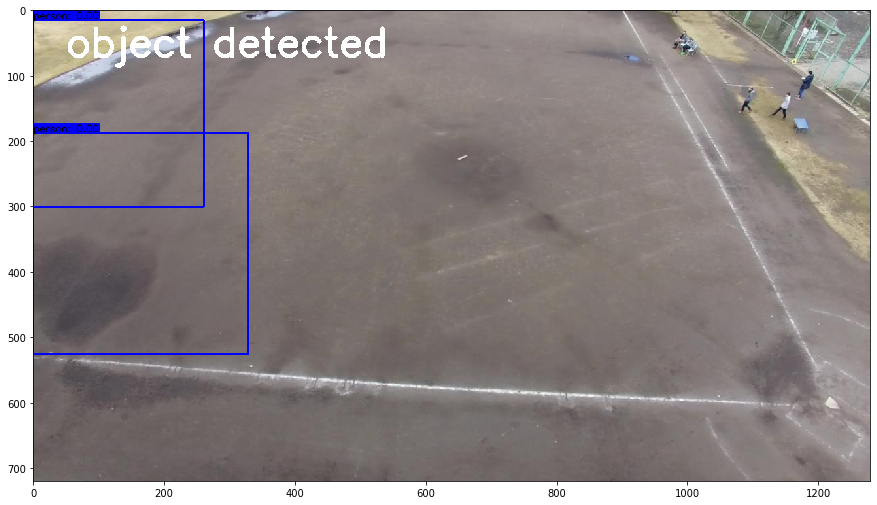

In [91]:
fig, ax = plt.subplots(figsize=(15,22))
plt.imshow(out)

In [43]:
frame

array([[[145, 171, 187],
        [146, 172, 188],
        [147, 173, 189],
        ...,
        [ 60,  49,  45],
        [ 59,  48,  44],
        [ 59,  48,  44]],

       [[143, 169, 185],
        [144, 170, 186],
        [146, 172, 188],
        ...,
        [ 60,  49,  45],
        [ 59,  48,  44],
        [ 59,  48,  44]],

       [[143, 169, 185],
        [145, 171, 187],
        [148, 174, 190],
        ...,
        [ 60,  49,  45],
        [ 59,  48,  44],
        [ 59,  48,  44]],

       ...,

       [[171, 226, 241],
        [171, 226, 241],
        [171, 226, 241],
        ...,
        [161, 171, 158],
        [181, 191, 178],
        [186, 199, 185]],

       [[173, 228, 243],
        [173, 228, 243],
        [173, 228, 243],
        ...,
        [163, 173, 160],
        [179, 189, 176],
        [192, 205, 191]],

       [[174, 229, 244],
        [174, 229, 244],
        [174, 229, 244],
        ...,
        [141, 151, 138],
        [156, 166, 153],
        [179, 192, 178]]